In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

DATA_ROOT = "/kaggle/input/camelyon-prepro-v4-patches"
CSV_PATH  = os.path.join(DATA_ROOT, "patches_metadata.csv")

df = pd.read_csv(CSV_PATH)
print("Nombre total de patchs :", len(df))
df.head()


Nombre total de patchs : 16800


,patch_path,wsi_id,x,y,label
0,/kaggle/working/patches/normal_074_x54016_y698...,normal_074,54016,69888,0
1,/kaggle/working/patches/normal_074_x18688_y744...,normal_074,18688,74496,0
2,/kaggle/working/patches/normal_074_x48640_y757...,normal_074,48640,75776,0
3,/kaggle/working/patches/normal_074_x50688_y757...,normal_074,50688,75776,0
4,/kaggle/working/patches/normal_074_x50944_y757...,normal_074,50944,75776,0


In [2]:
# Liste WSI uniques + leurs labels
wsi_df = df.groupby("wsi_id")["label"].first().reset_index()

print("Nombre total de WSI :", len(wsi_df))
print("Répartition des WSI par label :")
print(wsi_df["label"].value_counts())
wsi_df.head()


Nombre total de WSI : 56
Répartition des WSI par label :
label
1    32
0    24
Name: count, dtype: int64


,wsi_id,label
0,normal_074,0
1,normal_077,0
2,normal_078,0
3,normal_081,0
4,normal_088,0


In [3]:
# 15% test
trainval_wsi, test_wsi = train_test_split(
    wsi_df,
    test_size=0.15,
    stratify=wsi_df["label"],
    random_state=42
)

# 15% val sur trainval
train_wsi, val_wsi = train_test_split(
    trainval_wsi,
    test_size=0.15,
    stratify=trainval_wsi["label"],
    random_state=42
)

print("Train WSI:", len(train_wsi))
print("Val WSI:", len(val_wsi))
print("Test WSI:", len(test_wsi))


Train WSI: 39
Val WSI: 8
Test WSI: 9


In [4]:
df["split"] = "none"

df.loc[df["wsi_id"].isin(train_wsi["wsi_id"]), "split"] = "train"
df.loc[df["wsi_id"].isin(val_wsi["wsi_id"]),   "split"] = "val"
df.loc[df["wsi_id"].isin(test_wsi["wsi_id"]),  "split"] = "test"

print(df["split"].value_counts())


split
train    11700
test      2700
val       2400
Name: count, dtype: int64


In [5]:
df.groupby(["split", "label"])["patch_path"].count()


split  label
test   0        1200
       1        1500
train  0        5100
       1        6600
val    0         900
       1        1500
Name: patch_path, dtype: int64

In [6]:
OUT_CSV_PATH = "/kaggle/working/patches_metadata_with_split.csv"
df.to_csv(OUT_CSV_PATH, index=False)

print("CSV final sauvegardé :", OUT_CSV_PATH)


CSV final sauvegardé : /kaggle/working/patches_metadata_with_split.csv


<Figure size 800x500 with 0 Axes>

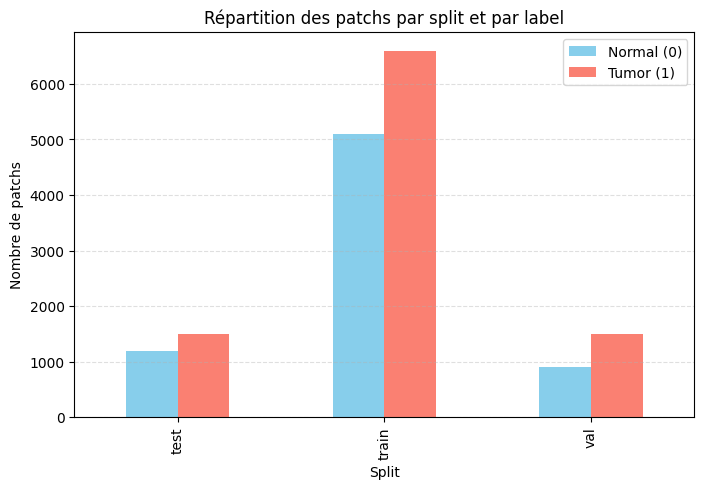

In [7]:
import matplotlib.pyplot as plt

# Comptage par split et par label
counts = df.groupby(["split", "label"]).size().unstack(fill_value=0)

plt.figure(figsize=(8,5))
counts.plot(kind="bar", stacked=False, color=["skyblue", "salmon"], figsize=(8,5))

plt.title("Répartition des patchs par split et par label")
plt.xlabel("Split")
plt.ylabel("Nombre de patchs")
plt.legend(["Normal (0)", "Tumor (1)"])
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.show()


In [8]:
# === WSI-level counts ===
wsi_split_df = df.groupby("wsi_id").agg(
    label=("label", "first"),
    split=("split", "first")
).reset_index()

print("Nb WSI total:", len(wsi_split_df))
print("\nWSI par split :")
print(wsi_split_df["split"].value_counts())

print("\nWSI par split x label :")
wsi_counts = wsi_split_df.groupby(["split", "label"]).size().unstack(fill_value=0)
wsi_counts


Nb WSI total: 56

WSI par split :
split
train    39
test      9
val       8
Name: count, dtype: int64

WSI par split x label :


label,0,1
split,,
test,4,5
train,17,22
val,3,5


<Figure size 700x400 with 0 Axes>

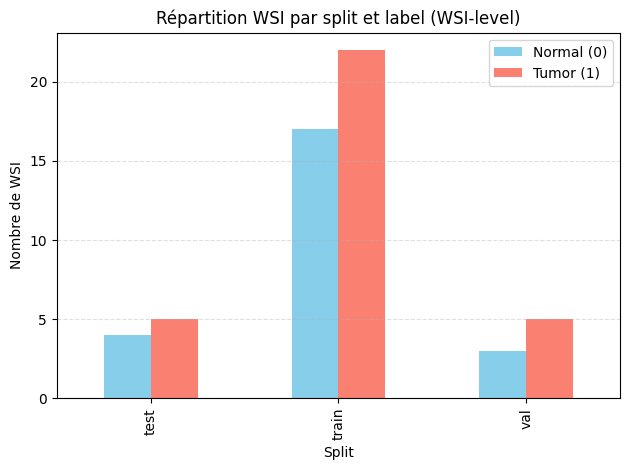

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
wsi_counts.plot(kind="bar", stacked=False, color=["skyblue", "salmon"])

plt.title("Répartition WSI par split et label (WSI-level)")
plt.xlabel("Split")
plt.ylabel("Nombre de WSI")
plt.legend(["Normal (0)", "Tumor (1)"])
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


<Figure size 700x400 with 0 Axes>

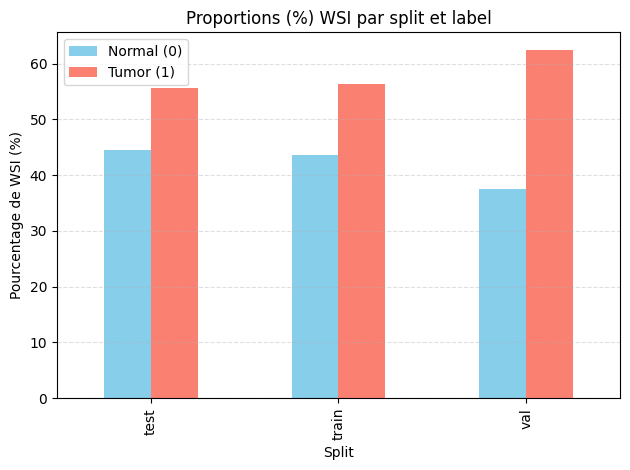

In [10]:
wsi_props = wsi_counts.div(wsi_counts.sum(axis=1), axis=0) * 100

plt.figure(figsize=(7,4))
wsi_props.plot(kind="bar", stacked=False, color=["skyblue", "salmon"])

plt.title("Proportions (%) WSI par split et label")
plt.xlabel("Split")
plt.ylabel("Pourcentage de WSI (%)")
plt.legend(["Normal (0)", "Tumor (1)"])
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()
